# Combinatorial Optimization with Physics-Inspired Graph Neural Networks

In this notebook we show how to solve combinatorial optimization problems with physics-inspired graph neural networks, as outlined in M. J. A. Schuetz, J. K. Brubaker, H. G. Katzgraber, _Combinatorial Optimization with Physics-Inspired Graph Neural Networks_, [arXiv:2107.01188](https://arxiv.org/abs/2107.01188). 
Here we focus on the canonical maximum independent set (MIS) problem, but our approach can easily be extended to other combinatorial optimization problems. 
For the actual implementation of the graph neural network we use the open-source ```dgl``` library. 

Please note we have provided a `requirements.txt` file, which defines the environment required to run this code. Because some of the packages are not available on default OSX conda channels, we have also provided suggested channels to find them on. These can be distilled into a single line as such:

> conda create -n \<environment_name\> python=3 --file requirements.txt -c conda-forge -c dglteam -c pytorch

In [1]:
import dgl
import torch
import random
import os
import numpy as np
import pandas as pd
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F
import warnings

from collections import OrderedDict, defaultdict
from dgl.nn.pytorch import GraphConv
from itertools import chain, islice, combinations, product
from networkx.algorithms.approximation import maximum_independent_set as mis
from time import time
from tqdm import tqdm
from ray import tune


from utils import generate_graph, get_gnn, run_gnn_training, qubo_dict_to_torch, gen_combinations, loss_func

# MacOS can have issues with MKL. For more details, see
# https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

c:\Users\roman\Documents\20_Git_workspace\VP2\vp2\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# fix seed to ensure consistent results
seed_value = 1
random.seed(seed_value)        # seed python RNG
np.random.seed(seed_value)     # seed global NumPy RNG
torch.manual_seed(seed_value)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


# Step 0 - Define utility functions

We first load a few general utility functions from ```utils.py``` before defining some helper functions specific to the MIS problem. 

### General utilities

### Problem-specific (MIS) utilities

In [3]:
# helper function to generate Q matrix for Maximum Independent Set problem (MIS)
def gen_q_dict_mis(nx_G, penalty=2):
    """
    Helper function to generate QUBO matrix for MIS as minimization problem.
    
    Input:
        nx_G: graph as networkx graph object (assumed to be unweigthed)
    Output:
        Q_dic: QUBO as defaultdict
    """

    # Initialize our Q matrix
    Q_dic = defaultdict(int)

    # Update Q matrix for every edge in the graph
    # all off-diagonal terms get penalty
    for (u, v) in nx_G.edges:
        Q_dic[(u, v)] = penalty

    # all diagonal terms get -1
    for u in nx_G.nodes:
        Q_dic[(u, u)] = -1

    return Q_dic


# Run classical MIS solver (provided by NetworkX)
def run_mis_solver(nx_graph):
    """
    helper function to run traditional solver for MIS.
    
    Input:
        nx_graph: networkx Graph object
    Output:
        ind_set_bitstring_nx: bitstring solution as list
        ind_set_nx_size: size of independent set (int)
        number_violations: number of violations of ind.set condition
    """
    # compare with traditional solver
    t_start = time()
    ind_set_nx = mis(nx_graph)
    t_solve = time() - t_start
    ind_set_nx_size = len(ind_set_nx)

    # get bitstring list
    nx_bitstring = [1 if (node in ind_set_nx) else 0 for node in sorted(list(nx_graph.nodes))]
    edge_set = set(list(nx_graph.edges))

    # Updated to be able to handle larger scale
    print('Calculating violations...')
    # check for violations
    number_violations = 0
    for ind_set_chunk in gen_combinations(combinations(ind_set_nx, 2), 100000):
        number_violations += len(set(ind_set_chunk).intersection(edge_set))

    return nx_bitstring, ind_set_nx_size, number_violations, t_solve


# Calculate results given bitstring and graph definition, includes check for violations
def postprocess_gnn_mis(best_bitstring, nx_graph):
    """
    helper function to postprocess MIS results

    Input:
        best_bitstring: bitstring as torch tensor
    Output:
        size_mis: Size of MIS (int)
        ind_set: MIS (list of integers)
        number_violations: number of violations of ind.set condition
    """

    # get bitstring as list
    bitstring_list = list(best_bitstring)

    # compute cost
    size_mis = sum(bitstring_list)

    # get independent set
    ind_set = set([node for node, entry in enumerate(bitstring_list) if entry == 1])
    edge_set = set(list(nx_graph.edges))

    print('Calculating violations...')
    # check for violations
    number_violations = 0
    for ind_set_chunk in gen_combinations(combinations(ind_set, 2), 100000):
        number_violations += len(set(ind_set_chunk).intersection(edge_set))

    return size_mis, ind_set, number_violations

# Step 1 - Build correlation matrix

In [4]:
sp500_hist = pd.read_csv(
    "sp500_hist_prices.csv",
    parse_dates=['Date'],
    index_col='Date'
)

# drop columns with more than 60% NaN values
sp500_hist.dropna(axis=1, thresh=int(len(sp500_hist)*0.4), inplace=True)

# drop columns with negative values in it
sp500_hist.drop(
    columns=sp500_hist.columns[(sp500_hist < 0).any()].values, 
    axis=1,
    inplace=True)

# reduce dataset
sp500_hist = sp500_hist

print(f'Shape: {sp500_hist.shape}')
sp500_hist.head()

Shape: (4279, 484)


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,20.439508,35.305668,38.559849,2.272182,NaN,16.348289,12.590348,6.120000,21.528095,38.520000,...,29.771492,9.832613,32.591091,24.051765,NaN,12.118679,60.463249,42.830002,58.061222,NaN
2006-01-04,20.494427,36.955471,38.834522,2.278869,NaN,16.239967,12.609449,6.151111,21.645647,38.419998,...,29.716309,9.880271,32.646824,24.274343,NaN,12.222367,61.037167,42.410000,58.471172,NaN
2006-01-05,21.031340,37.436260,39.020573,2.260936,NaN,16.038809,12.771802,6.061111,21.807291,38.070000,...,29.539726,9.874971,32.485168,23.998352,NaN,12.743404,60.392624,42.529999,59.002590,NaN
2006-01-06,21.141167,36.766926,38.976273,2.319297,NaN,15.860854,13.016929,6.173333,22.887375,39.000000,...,29.821157,9.912039,33.126179,24.372272,NaN,12.707114,60.083572,44.119999,59.617485,NaN
2006-01-09,21.080151,36.399242,39.481319,2.311697,NaN,15.860854,13.500801,6.116667,22.821247,38.380001,...,31.228340,9.885561,33.109463,24.612658,NaN,12.805617,62.211487,44.790001,59.124062,NaN


In [5]:
METHOD = 'pct'

if METHOD == 'standard':
    df_corr = sp500_hist.corr(method='pearson').abs()
elif METHOD == 'pct':
    sp500_pct = sp500_hist.pct_change()
    sp500_pct = sp500_pct.groupby(sp500_pct.index.year).sum()
    df_corr = sp500_pct.corr(method='pearson').abs()
else:
    raise KeyError("METHOD must be either 'standard' or 'pct'")

df_corr

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.060148,0.157241,0.768849,0.296156,0.650578,0.280147,0.065514,0.525189,0.790364,...,0.663047,0.471917,0.115992,0.529148,0.344200,0.557185,0.697162,0.603583,0.371461,0.250599
AAL,0.060148,1.000000,0.224094,0.215877,0.164439,0.274348,0.071334,0.097154,0.294366,0.025244,...,0.136421,0.057326,0.076684,0.035960,0.131628,0.089025,0.251139,0.095523,0.689320,0.051941
AAP,0.157241,0.224094,1.000000,0.165893,0.082694,0.154293,0.043957,0.207145,0.259158,0.164824,...,0.131879,0.061767,0.195827,0.045652,0.028089,0.217367,0.085204,0.624863,0.294638,0.308580
AAPL,0.768849,0.215877,0.165893,1.000000,0.003183,0.427384,0.358726,0.077663,0.506498,0.652120,...,0.574399,0.493280,0.225341,0.760153,0.207377,0.590832,0.523787,0.606444,0.032689,0.338361
ABBV,0.296156,0.164439,0.082694,0.003183,1.000000,0.438390,0.375691,0.005438,0.133962,0.328067,...,0.171925,0.139648,0.085694,0.013000,0.737339,0.013464,0.284705,0.219766,0.231086,0.287347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.557185,0.089025,0.217367,0.590832,0.013464,0.143048,0.306183,0.011620,0.482253,0.336445,...,0.609360,0.244276,0.057292,0.453082,0.186298,1.000000,0.051380,0.438750,0.356881,0.203073
ZBH,0.697162,0.251139,0.085204,0.523787,0.284705,0.569873,0.224853,0.292309,0.355824,0.682151,...,0.624609,0.645481,0.126241,0.508549,0.354637,0.051380,1.000000,0.356322,0.205201,0.126459
ZBRA,0.603583,0.095523,0.624863,0.606444,0.219766,0.221410,0.511447,0.230220,0.685547,0.754664,...,0.187514,0.382681,0.501544,0.435461,0.520876,0.438750,0.356322,1.000000,0.397458,0.798334
ZION,0.371461,0.689320,0.294638,0.032689,0.231086,0.245172,0.112833,0.364542,0.521887,0.176920,...,0.348359,0.152980,0.070638,0.138350,0.411440,0.356881,0.205201,0.397458,1.000000,0.294993


In [6]:
df_corr.describe()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
count,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,...,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000
mean,0.506297,0.223431,0.210457,0.446698,0.227388,0.381237,0.267273,0.199907,0.448440,0.454357,...,0.395910,0.339142,0.228000,0.429103,0.310935,0.336834,0.427163,0.426707,0.323515,0.314372
std,0.236545,0.172122,0.141183,0.226584,0.153475,0.183304,0.169582,0.161656,0.213368,0.223387,...,0.202376,0.179704,0.173747,0.200260,0.191752,0.181676,0.209262,0.200708,0.182889,0.202766
min,0.002699,0.000118,0.000088,0.003183,0.001336,0.005008,0.000293,0.000129,0.001045,0.003342,...,0.000290,0.000016,0.000259,0.001705,0.000269,0.000073,0.006582,0.002556,0.001881,0.000978
25%,0.302443,0.090328,0.099535,0.269340,0.107051,0.248484,0.129812,0.073419,0.276665,0.285438,...,0.227385,0.211902,0.087841,0.291272,0.154237,0.197280,0.273821,0.284115,0.186960,0.150149
50%,0.535351,0.181212,0.201765,0.435520,0.208785,0.394875,0.242091,0.164115,0.473584,0.485860,...,0.402103,0.357807,0.196977,0.449676,0.289118,0.325834,0.449232,0.452322,0.318251,0.293004
75%,0.703073,0.336138,0.296703,0.636013,0.331365,0.518713,0.381456,0.286818,0.618283,0.639060,...,0.555242,0.469281,0.327914,0.590836,0.453651,0.470022,0.597282,0.577199,0.442642,0.448560
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df_corr.quantile(0.5).mean()

0.3612086905103364

In [8]:
df_corr.where(df_corr >= 0.5).count().sum(), df_corr.where(df_corr < 0.5).count().sum()

(65004, 169252)

# Step 3 - Generate Graph

In [9]:
def build_nx_graph(df_corr:pd.DataFrame, threshold:float) -> nx.Graph:
    """ Returns a Networkx.Graph from a correlation matrix.
        Args:
            df_corr (pd.DataFrame): Correlation matrix
            threshold (float): edges with an correlation coefficient smaller
                than the treshold will be removed. 
                Note: The treshold bust be choosen reasonalbe, the graph must
                not be disconnected.
        Returns:
            nx.Graph
    """
    cor_matrix = df_corr.values.astype('float')
    sim_matrix = 1 - cor_matrix
    G = nx.from_numpy_array(sim_matrix)

    stock_names = df_corr.index.values
    # G = nx.relabel_nodes(G, lambda x: stock_names[x])
    # G.edges(data=True)
    H = G.copy()

    for (u, v, wt) in G.edges.data('weight'):

        if wt >= 1 - threshold:
            H.remove_edge(u, v)

        if u == v:
            H.remove_edge(u, v)

    return H

In [10]:
nx_graph = build_nx_graph(
    df_corr=df_corr,
    threshold=0.5
)

assert nx.is_connected(nx_graph), 'Graph is not connected. Try to lower the threshold'

In [11]:
assert (df_corr.where(df_corr >= 0.5).count().sum() - len(df_corr)) / 2 == len(nx_graph.edges)

In [12]:
# Constructs a random d-regular or p-probabilistic graph
# nx_graph = generate_graph(n=n, d=d, p=p, graph_type=graph_type, random_seed=seed_value)
# get DGL graph from networkx graph, load onto device
graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)

gen_q_dict_mis(nx_graph)

# Construct Q matrix for graph
q_torch = qubo_dict_to_torch(
    nx_graph, 
    gen_q_dict_mis(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

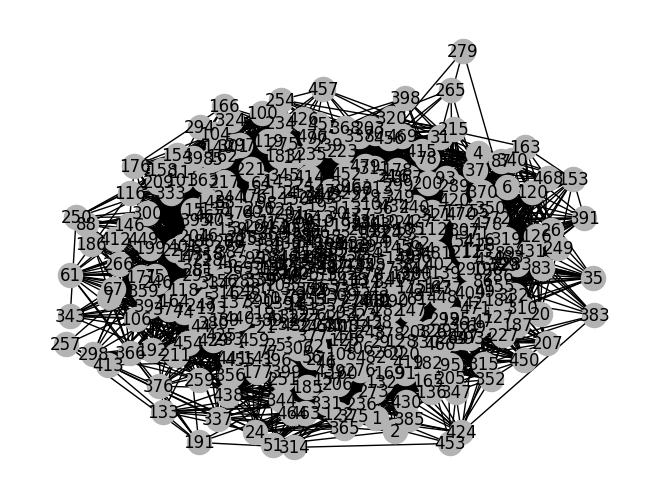

In [13]:
# Visualize graph
pos = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

# Step 3 - Set up optimizer/GNN architecture

In [14]:
def objective(config):
    results = {}

    net, embed, optimizer = get_gnn(
        n_nodes=n, 
        params=config, 
        model_type=config["model"], 
        torch_device=TORCH_DEVICE, 
        torch_dtype=TORCH_DTYPE)   
    
    gnn_start = time()

    net, epoch, final_bitstring, best_bitstring, best_loss, inputs, loss_hist, epoch_hist = run_gnn_training(
        q_torch=q_torch, 
        dgl_graph=graph_dgl, 
        net=net, 
        embed=embed, 
        optimizer=optimizer, 
        number_epochs=config['number_epochs'],
        tol=config['tolerance'], 
        patience=config['patience'], 
        prob_threshold=config['prob_threshold'])

    gnn_time = time() - gnn_start

    # post-processing
    final_loss = loss_func(final_bitstring.float(), q_torch)

    # Process bitstring reported by GNN
    size_mis, ind_set, number_violations = postprocess_gnn_mis(best_bitstring, nx_graph)

    # Gathering results
    results["gnn_time"] = gnn_time
    results["final_bitstring"] = final_bitstring
    results["best_bitstring"] = best_bitstring
    results["best_loss"] = best_loss.item()
    results["final_loss"] = final_loss.item()
    results["size_mis"] = size_mis.item()
    results["ind_set"] = ind_set
    results["number_violations"] = number_violations
    results["loss_hist"] = loss_hist
    results["epoch_hist"] = epoch_hist

    return results


n = len(nx_graph.nodes)

search_space = {
    "lr": tune.grid_search([1e-3, 1e-4]),
    "dim_embedding": tune.choice([int(np.sqrt(n))]),
    'hidden_dim': tune.choice([int(np.sqrt(n) / 2)]),
    'dropout': tune.grid_search([0.0, 0.05, 0.1]),
    'number_classes': tune.choice([1]),
    'prob_threshold': tune.choice([0.5]),
    'number_epochs': tune.choice([50_000]),
    'tolerance': tune.choice([1e-4]),
    'patience': tune.choice([1000]),
    'model': tune.grid_search(["GCN_2L_Model", "SAGE_2L_Model", 
                          "GAT_2L_1H_Model", "GAT_2L_2H_Model", "GAT_2L_4H_Model",
                          "GCN_1L_Model", "SAGE_1L_Model",
                          "GAT_1L_1H_Model", "GAT_1L_2H_Model", "GAT_1L_4H_Model"]),
}

In [15]:
tuner = tune.Tuner(objective, param_space=search_space)
results = tuner.fit()

2023-05-10 16:51:06,913	INFO worker.py:1625 -- Started a local Ray instance.
2023-05-10 16:51:09,954	INFO tune.py:218 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.


(objective pid=2656) c:\Users\roman\Documents\20_Git_workspace\VP2\vp2\.venv\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
(objective pid=2656)   assert input.numel() == input.storage().size(), (


(objective pid=2656) Epoch: 0, Loss: 13933.16015625


(objective pid=8824)   assert input.numel() == input.storage().size(), (
(objective pid=8824)   assert input.numel() == input.storage().size(), (


(objective pid=8824) Epoch: 0, Loss: 16237.2705078125
(objective pid=2656) Epoch: 1000, Loss: 7.814560890197754


(objective pid=28620) c:\Users\roman\Documents\20_Git_workspace\VP2\vp2\.venv\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
(objective pid=28620)   assert input.numel() == input.storage().size(), (


(objective pid=28620) Epoch: 0, Loss: 14894.865234375
(objective pid=8824) Epoch: 1000, Loss: 7.029317378997803


(objective pid=17500)   assert input.numel() == input.storage().size(), (
(objective pid=17500)   assert input.numel() == input.storage().size(), (


(objective pid=17500) Epoch: 0, Loss: 16767.158203125 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


(objective pid=22844)   assert input.numel() == input.storage().size(), (
(objective pid=22844)   assert input.numel() == input.storage().size(), (


(objective pid=26204) c:\Users\roman\Documents\20_Git_workspace\VP2\vp2\.venv\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
(objective pid=26204)   assert input.numel() == input.storage().size(), (


(objective pid=2656) Epoch: 6000, Loss: 0.03429700806736946 [repeated 6x across cluster]
(objective pid=2656) Stopping early on epoch 6233 (patience: 1000)
(objective pid=2656) GNN training (n=484) took 56.577
(objective pid=2656) GNN final continuous loss: 0.013812963850796223
(objective pid=2656) GNN best continuous loss: 0.0
(objective pid=2656) Calculating violations...


(objective pid=20940)   assert input.numel() == input.storage().size(), (
(objective pid=20940)   assert input.numel() == input.storage().size(), (


(objective pid=20940) Epoch: 0, Loss: 30863.185546875
(objective pid=22616) Epoch: 3000, Loss: 89.8478775024414


(objective pid=23976) c:\Users\roman\Documents\20_Git_workspace\VP2\vp2\.venv\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
(objective pid=23976)   assert input.numel() == input.storage().size(), (


(objective pid=23976) Epoch: 0, Loss: 64036.0 [repeated 6x across cluster]
(objective pid=26204) Epoch: 2000, Loss: -2.9385485649108887 [repeated 7x across cluster]


(objective pid=28620) Epoch: 7000, Loss: -0.007144002243876457 [repeated 5x across cluster]


(objective pid=4816) c:\Users\roman\Documents\20_Git_workspace\VP2\vp2\.venv\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
(objective pid=4816)   assert input.numel() == input.storage().size(), (


(objective pid=4816) Epoch: 0, Loss: 59122.51171875 [repeated 4x across cluster]
(objective pid=26204) Stopping early on epoch 3093 (patience: 1000)
(objective pid=26204) GNN training (n=484) took 46.958
(objective pid=26204) GNN final continuous loss: -2.9853339195251465
(objective pid=26204) GNN best continuous loss: -2.9853339195251465
(objective pid=26204) Calculating violations...
(objective pid=23976) Epoch: 2000, Loss: 0.008260409347712994 [repeated 8x across cluster]


(objective pid=19820)   assert input.numel() == input.storage().size(), (
(objective pid=19820)   assert input.numel() == input.storage().size(), (


(objective pid=17500) Epoch: 8000, Loss: 2.250570297241211 [repeated 3x across cluster]
(objective pid=8700) Epoch: 2000, Loss: -20.844684600830078 [repeated 6x across cluster]


(objective pid=23096) c:\Users\roman\Documents\20_Git_workspace\VP2\vp2\.venv\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
(objective pid=23096)   assert input.numel() == input.storage().size(), (


(objective pid=17500) Epoch: 9000, Loss: 1.2333855628967285 [repeated 3x across cluster]
(objective pid=19820) Stopping early on epoch 1000 (patience: 1000)
(objective pid=19820) GNN training (n=484) took 18.024
(objective pid=19820) GNN final continuous loss: -9.886204995085931e-21
(objective pid=19820) GNN best continuous loss: -8.693166325679513e-11
(objective pid=19820) Calculating violations...
(objective pid=4816) Epoch: 2000, Loss: 54.609588623046875 [repeated 7x across cluster]


(objective pid=22780)   assert input.numel() == input.storage().size(), (
(objective pid=22780)   assert input.numel() == input.storage().size(), (


(objective pid=22616) Epoch: 9000, Loss: 1.5469578504562378 [repeated 3x across cluster]
(objective pid=20940) Epoch: 5000, Loss: -24.977439880371094 [repeated 6x across cluster]


(objective pid=24252) c:\Users\roman\Documents\20_Git_workspace\VP2\vp2\.venv\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
(objective pid=24252)   assert input.numel() == input.storage().size(), (


(objective pid=8700) Stopping early on epoch 3749 (patience: 1000)
(objective pid=8700) GNN training (n=484) took 65.158
(objective pid=8700) GNN final continuous loss: -21.979820251464844
(objective pid=8700) GNN best continuous loss: -21.979820251464844
(objective pid=8700) Calculating violations...
(objective pid=17500) Epoch: 11000, Loss: 0.3685300648212433 [repeated 3x across cluster]
(objective pid=23976) Epoch: 5000, Loss: 0.004200370516628027 [repeated 5x across cluster]


(objective pid=17568)   assert input.numel() == input.storage().size(), (
(objective pid=17568)   assert input.numel() == input.storage().size(), (


Trial name,best_bitstring,best_loss,date,done,epoch_hist,experiment_tag,final_bitstring,final_loss,gnn_time,hostname,ind_set,iterations_since_restore,loss_hist,node_ip,number_violations,pid,size_mis,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
objective_19eb8_00000,"tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])",0,2023-05-10_16-52-14,True,"[0, 1000, 2000, 3000, 4000, 5000, 6000]","0_dim_embedding=22,dropout=0.0000,hidden_dim=11,lr=0.0010,model=GCN_2L_Model,number_classes=1,number_epochs=50000,patience=1000,prob_threshold=0.5000,tolerance=0.0001","tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])",0,56.5788,LAPTOP-LH51KM5C,set(),1,"[13933.16

(objective pid=20940) Epoch: 6000, Loss: -24.999683380126953 [repeated 6x across cluster]
(objective pid=28620) Epoch: 13000, Loss: -4.976880073547363 [repeated 6x across cluster]
(objective pid=22780) Epoch: 1000, Loss: 7.4865403175354 [repeated 2x across cluster]
(objective pid=17500) Epoch: 13000, Loss: 0.10050977021455765 [repeated 2x across cluster]
(objective pid=28620) Epoch: 14000, Loss: -14.751133918762207 [repeated 4x across cluster]
(objective pid=17500) Stopping early on epoch 13411 (patience: 1000)
(objective pid=17500) GNN training (n=484) took 166.253
(objective pid=17500) GNN final continuous loss: 0.0744253396987915
(objective pid=17500) GNN best continuous loss: 0.0
(objective pid=17500) Calculating violations...
(objective pid=22844) Epoch: 12000, Loss: 0.33953797817230225 [repeated 5x across cluster]
(objective pid=28620) Epoch: 15000, Loss: -16.93416404724121 [repeated 6x across cluster]
(objective pid=22844) Epoch: 13000, Loss: 0.1726924329996109 [repeated 5x acro

2023-05-10 17:22:54,714	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.544 s, which may be a performance bottleneck.
2023-05-10 17:22:54,717	WARNING util.py:244 -- The `process_trial_result` operation took 0.548 s, which may be a performance bottleneck.
2023-05-10 17:22:54,719	WARNING util.py:244 -- Processing trial results took 0.550 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:22:54,721	WARNING util.py:244 -- The `process_trial_result` operation took 0.560 s, which may be a performance bottleneck.


(objective pid=20940) Conv1: torch.Size([484, 11])
(objective pid=20940) Conv1: torch.Size([484, 11])
(objective pid=20940) Conv1: torch.Size([484, 11])
(objective pid=20940) Conv1: torch.Size([484, 11])
(objective pid=20940) Conv1: torch.Size([484, 11])
(objective pid=20940) Conv1: torch.Size([484, 11])
(objective pid=20940) Conv1: torch.Size([484, 11])
(objective pid=20940) Conv1: torch.Size([484, 11])
(objective pid=20940) Conv1: torch.Size([484, 11])
(objective pid=20940) Conv1: torch.Size([484, 11])
(objective pid=20940) Conv1: torch.Size([484, 11])
(objective pid=20940) Conv1: torch.Size([484, 11])
(objective pid=20940) Conv1: torch.Size([484, 11])
(objective pid=20940) Conv1: torch.Size([484, 11])
(objective pid=20940) Conv1: torch.Size([484, 11])
(objective pid=20940) Conv1: torch.Size([484, 11])
(objective pid=20940) Conv1: torch.Size([484, 11])
(objective pid=20940) Conv1: torch.Size([484, 11])
(objective pid=20940) Conv1: torch.Size([484, 11])
(objective pid=20940) Conv1: to

2023-05-10 17:23:57,529	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.524 s, which may be a performance bottleneck.
2023-05-10 17:23:57,531	WARNING util.py:244 -- The `process_trial_result` operation took 0.526 s, which may be a performance bottleneck.
2023-05-10 17:23:57,533	WARNING util.py:244 -- Processing trial results took 0.528 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:23:57,531	WARNING util.py:244 -- The `process_trial_result` operation took 0.526 s, which may be a performance bottleneck.
2023-05-10 17:23:57,533	WARNING util.py:244 -- Processing trial results took 0.528 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:23:57,537	WARNING util.py:244 -- The `process_trial_result` operation took 0.541 s, which may be a performance bottleneck.


(objective pid=20940) Conv1: torch.Size([484, 11])
(objective pid=23976) Conv1: torch.Size([484, 11]) [repeated 468x across cluster]
(objective pid=26204) Epoch: 35000, Loss: -7.563964366912842
(objective pid=20940) Conv1: torch.Size([484, 11]) [repeated 541x across cluster]
(objective pid=22616) Epoch: 10000, Loss: 1.2865625619888306 [repeated 2x across cluster]
(objective pid=20940) Conv1: torch.Size([484, 11]) [repeated 552x across cluster]
(objective pid=23976) Epoch: 4000, Loss: -28.998231887817383 [repeated 2x across cluster]
(objective pid=20940) Conv1: torch.Size([484, 11]) [repeated 559x across cluster]
(objective pid=20940) Epoch: 1000, Loss: -1.85574471950531 [repeated 3x across cluster]
(objective pid=20940) Conv1: torch.Size([484, 11]) [repeated 558x across cluster]
(objective pid=22780) Epoch: 36000, Loss: -0.9999998807907104 [repeated 2x across cluster]
(objective pid=20940) Conv1: torch.Size([484, 11]) [repeated 569x across cluster]
(objective pid=22844) Epoch: 11000, L

2023-05-10 17:24:31,913	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.574 s, which may be a performance bottleneck.
2023-05-10 17:24:31,916	WARNING util.py:244 -- The `process_trial_result` operation took 0.577 s, which may be a performance bottleneck.
2023-05-10 17:24:31,919	WARNING util.py:244 -- Processing trial results took 0.580 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:24:31,921	WARNING util.py:244 -- The `process_trial_result` operation took 0.591 s, which may be a performance bottleneck.


(objective pid=17568) Epoch: 20000, Loss: -0.0002981906582135707 [repeated 2x across cluster]
(objective pid=20940) Conv1: torch.Size([484, 11]) [repeated 736x across cluster]
(objective pid=22616) Epoch: 12000, Loss: 0.3777318000793457 [repeated 4x across cluster]
(objective pid=20940) Conv1: torch.Size([484, 11]) [repeated 857x across cluster]
(objective pid=8824) Conv1: torch.Size([484, 11])
(objective pid=23976) Epoch: 6000, Loss: -28.999534606933594
(objective pid=20940) Conv1: torch.Size([484, 11]) [repeated 870x across cluster]
(objective pid=22780) Epoch: 1000, Loss: 0.5169728398323059 [repeated 3x across cluster]
(objective pid=20940) Conv1: torch.Size([484, 11]) [repeated 860x across cluster]
(objective pid=26204) Epoch: 36000, Loss: -9.28331184387207 [repeated 3x across cluster]
(objective pid=20940) Conv1: torch.Size([484, 11]) [repeated 859x across cluster]
(objective pid=2656) Conv1: torch.Size([484, 11])
(objective pid=22780) Conv1: torch.Size([484, 11]) [repeated 840x a

2023-05-10 17:26:33,501	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.624 s, which may be a performance bottleneck.
2023-05-10 17:26:33,503	WARNING util.py:244 -- The `process_trial_result` operation took 0.628 s, which may be a performance bottleneck.
2023-05-10 17:26:33,505	WARNING util.py:244 -- Processing trial results took 0.630 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:26:33,507	WARNING util.py:244 -- The `process_trial_result` operation took 0.642 s, which may be a performance bottleneck.
2023-05-10 17:26:33,503	WARNING util.py:244 -- The `process_trial_result` operation took 0.628 s, which may be a performance bottleneck.
2023-05-10 17:26:33,505	WARNING util.py:244 -- Processing trial results took 0.630 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:26:33,507	WARNING util.py:244 -- The `process_trial_resul

(objective pid=23976) Epoch: 12000, Loss: -28.999998092651367 [repeated 4x across cluster]
(objective pid=8824) Conv1: torch.Size([484, 11]) [repeated 939x across cluster]
(objective pid=23096) Epoch: 27000, Loss: -8.938446044921875 [repeated 6x across cluster]
(objective pid=8824) Conv1: torch.Size([484, 11]) [repeated 1148x across cluster]
(objective pid=17568) Epoch: 22000, Loss: -4.727344036102295 [repeated 2x across cluster]
(objective pid=8824) Conv1: torch.Size([484, 11]) [repeated 1141x across cluster]
(objective pid=22616) Conv1: torch.Size([484, 11])
(objective pid=20940) Conv1: torch.Size([484, 11]) [repeated 1134x across cluster]
(objective pid=8824) Epoch: 1000, Loss: 193.12884521484375
(objective pid=20940) Conv1: torch.Size([484, 11]) [repeated 1129x across cluster]
(objective pid=20940) Epoch: 10000, Loss: -32.44856262207031 [repeated 3x across cluster]
(objective pid=20940) Conv1: torch.Size([484, 11]) [repeated 1131x across cluster]
(objective pid=22616) Conv1: torch.

2023-05-10 17:27:51,127	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.622 s, which may be a performance bottleneck.
2023-05-10 17:27:51,129	WARNING util.py:244 -- The `process_trial_result` operation took 0.624 s, which may be a performance bottleneck.
2023-05-10 17:27:51,133	WARNING util.py:244 -- Processing trial results took 0.627 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:27:51,135	WARNING util.py:244 -- The `process_trial_result` operation took 0.641 s, which may be a performance bottleneck.


(objective pid=19820) Epoch: 10000, Loss: 0.07755648344755173 [repeated 3x across cluster]
(objective pid=22844) Epoch: 13000, Loss: 0.00018242551595903933 [repeated 5x across cluster]
(objective pid=20940) Conv1: torch.Size([484, 11]) [repeated 1102x across cluster]
(objective pid=8824) Conv1: torch.Size([484, 11]) [repeated 1126x across cluster]
(objective pid=8824) Epoch: 5000, Loss: 7.175599575042725
(objective pid=20940) Conv1: torch.Size([484, 11]) [repeated 1144x across cluster]
(objective pid=23976) Epoch: 17000, Loss: -29.0 [repeated 2x across cluster]
(objective pid=8824) Conv1: torch.Size([484, 11]) [repeated 1135x across cluster]
(objective pid=2656) Epoch: 44000, Loss: -9.99985122680664 [repeated 3x across cluster]
(objective pid=20940) Conv1: torch.Size([484, 11]) [repeated 1122x across cluster]
(objective pid=8824) Epoch: 6000, Loss: 2.8268344402313232
(objective pid=8824) Conv1: torch.Size([484, 11]) [repeated 1153x across cluster]
(objective pid=22616) Epoch: 28000, Lo

2023-05-10 17:33:01,989	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.640 s, which may be a performance bottleneck.
2023-05-10 17:33:01,991	WARNING util.py:244 -- The `process_trial_result` operation took 0.642 s, which may be a performance bottleneck.
2023-05-10 17:33:01,993	WARNING util.py:244 -- Processing trial results took 0.644 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:33:01,995	WARNING util.py:244 -- The `process_trial_result` operation took 0.656 s, which may be a performance bottleneck.


(objective pid=22780) Conv1: torch.Size([484, 11]) [repeated 1106x across cluster]
(objective pid=2656) Conv1: torch.Size([484, 11])
(objective pid=23976) Epoch: 34000, Loss: -30.0
(objective pid=8824) Conv1: torch.Size([484, 11]) [repeated 1135x across cluster]
(objective pid=8824) Epoch: 22000, Loss: -29.012514114379883 [repeated 3x across cluster]
(objective pid=8824) Conv1: torch.Size([484, 11]) [repeated 1161x across cluster]
(objective pid=22780) Epoch: 18000, Loss: -17.807443618774414 [repeated 2x across cluster]
(objective pid=22780) Conv1: torch.Size([484, 11]) [repeated 1129x across cluster]
(objective pid=22616) Epoch: 49000, Loss: -20.99953269958496
(objective pid=8824) Conv1: torch.Size([484, 11]) [repeated 1152x across cluster]
(objective pid=20940) Conv1: torch.Size([484, 11]) [repeated 1132x across cluster]
(objective pid=22616) GNN training (n=484) took 712.937
(objective pid=22616) GNN final continuous loss: -20.999435424804688
(objective pid=22616) GNN best continuou

2023-05-10 17:33:38,188	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.631 s, which may be a performance bottleneck.
2023-05-10 17:33:38,189	WARNING util.py:244 -- The `process_trial_result` operation took 0.632 s, which may be a performance bottleneck.
2023-05-10 17:33:38,192	WARNING util.py:244 -- Processing trial results took 0.636 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:33:38,195	WARNING util.py:244 -- The `process_trial_result` operation took 0.647 s, which may be a performance bottleneck.


(objective pid=23976) Conv1: torch.Size([484, 11]) [repeated 1115x across cluster]
(objective pid=22616) Epoch: 0, Loss: 11844.427734375
(objective pid=20940) Conv1: torch.Size([484, 11]) [repeated 1105x across cluster]
(objective pid=23976) Epoch: 36000, Loss: -30.0
(objective pid=8824) Conv1: torch.Size([484, 11]) [repeated 1137x across cluster]
(objective pid=20940) Epoch: 34000, Loss: -32.99995040893555 [repeated 4x across cluster]
(objective pid=8824) Conv1: torch.Size([484, 11]) [repeated 1146x across cluster]
(objective pid=20940) Conv1: torch.Size([484, 11]) [repeated 1136x across cluster]
(objective pid=2656) Epoch: 2000, Loss: -0.9728768467903137
(objective pid=8824) Conv1: torch.Size([484, 11]) [repeated 1110x across cluster]
(objective pid=23976) Conv1: torch.Size([484, 11])
(objective pid=8824) Epoch: 25000, Loss: -29.987966537475586
(objective pid=20940) Conv1: torch.Size([484, 11]) [repeated 1108x across cluster]
(objective pid=8700) Epoch: 33000, Loss: -2.99999737739563

2023-05-10 17:34:47,183	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.697 s, which may be a performance bottleneck.
2023-05-10 17:34:47,185	WARNING util.py:244 -- The `process_trial_result` operation took 0.699 s, which may be a performance bottleneck.
2023-05-10 17:34:47,187	WARNING util.py:244 -- Processing trial results took 0.701 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:34:47,189	WARNING util.py:244 -- The `process_trial_result` operation took 0.713 s, which may be a performance bottleneck.
2023-05-10 17:34:47,185	WARNING util.py:244 -- The `process_trial_result` operation took 0.699 s, which may be a performance bottleneck.
2023-05-10 17:34:47,187	WARNING util.py:244 -- Processing trial results took 0.701 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:34:47,189	WARNING util.py:244 -- The `process_trial_resul

(objective pid=8824) Conv1: torch.Size([484, 11]) [repeated 979x across cluster]
(objective pid=20940) Epoch: 0, Loss: 21815.857421875 [repeated 2x across cluster]
(objective pid=8824) Conv1: torch.Size([484, 11]) [repeated 812x across cluster]
(objective pid=22844) Conv1: torch.Size([484, 11])
(objective pid=23976) Epoch: 40000, Loss: -30.0
(objective pid=22780) Conv1: torch.Size([484, 11]) [repeated 849x across cluster]
(objective pid=8824) Epoch: 28000, Loss: -29.984302520751953 [repeated 2x across cluster]
(objective pid=8824) Conv1: torch.Size([484, 11]) [repeated 827x across cluster]
(objective pid=22780) Conv1: torch.Size([484, 11])
(objective pid=8824) Conv1: torch.Size([484, 11]) [repeated 763x across cluster]
(objective pid=23976) Epoch: 41000, Loss: -30.0
(objective pid=22616) Epoch: 3000, Loss: -0.32560086250305176 [repeated 2x across cluster]
(objective pid=23976) Conv1: torch.Size([484, 11]) [repeated 669x across cluster]
(objective pid=20940) Epoch: 1000, Loss: 6.2399973

2023-05-10 17:36:27,281	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.734 s, which may be a performance bottleneck.
2023-05-10 17:36:27,283	WARNING util.py:244 -- The `process_trial_result` operation took 0.737 s, which may be a performance bottleneck.
2023-05-10 17:36:27,285	WARNING util.py:244 -- Processing trial results took 0.739 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:36:27,287	WARNING util.py:244 -- The `process_trial_result` operation took 0.751 s, which may be a performance bottleneck.
2023-05-10 17:36:27,283	WARNING util.py:244 -- The `process_trial_result` operation took 0.737 s, which may be a performance bottleneck.
2023-05-10 17:36:27,285	WARNING util.py:244 -- Processing trial results took 0.739 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:36:27,287	WARNING util.py:244 -- The `process_trial_resul

(objective pid=8824) Conv1: torch.Size([484, 11]) [repeated 641x across cluster]
(objective pid=23976) Epoch: 0, Loss: 2216.17919921875 [repeated 5x across cluster]
(objective pid=22780) Conv1: torch.Size([484, 11]) [repeated 542x across cluster]
(objective pid=24252) Conv1: torch.Size([484, 11])
(objective pid=8824) Epoch: 33000, Loss: -29.98517608642578
(objective pid=22780) Conv1: torch.Size([484, 11]) [repeated 532x across cluster]
(objective pid=20940) Conv1: torch.Size([484, 11])
(objective pid=22844) Epoch: 18000, Loss: 1.621732735657133e-05
(objective pid=8824) Conv1: torch.Size([484, 11]) [repeated 530x across cluster]
(objective pid=22780) Epoch: 29000, Loss: -21.9671630859375 [repeated 2x across cluster]
(objective pid=22780) Conv1: torch.Size([484, 11]) [repeated 523x across cluster]
(objective pid=17500) Epoch: 38000, Loss: -29.988122940063477
(objective pid=22780) Conv1: torch.Size([484, 11]) [repeated 542x across cluster]
(objective pid=23096) Epoch: 36000, Loss: -10.997

2023-05-10 17:37:02,375	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.770 s, which may be a performance bottleneck.
2023-05-10 17:37:02,378	WARNING util.py:244 -- The `process_trial_result` operation took 0.773 s, which may be a performance bottleneck.
2023-05-10 17:37:02,380	WARNING util.py:244 -- Processing trial results took 0.775 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:37:02,382	WARNING util.py:244 -- The `process_trial_result` operation took 0.787 s, which may be a performance bottleneck.


(objective pid=22780) Conv1: torch.Size([484, 11]) [repeated 527x across cluster]
(objective pid=2656) Epoch: 0, Loss: 10838.9267578125 [repeated 2x across cluster]
(objective pid=22780) Conv1: torch.Size([484, 11]) [repeated 541x across cluster]
(objective pid=20940) Epoch: 4000, Loss: -2.9974381923675537
(objective pid=22780) Conv1: torch.Size([484, 11]) [repeated 548x across cluster]
(objective pid=8824) Conv1: torch.Size([484, 11])
(objective pid=22780) Conv1: torch.Size([484, 11]) [repeated 545x across cluster]
(objective pid=22780) Epoch: 31000, Loss: -22.99463653564453
(objective pid=26204) GNN training (n=484) took 2605.035
(objective pid=26204) GNN final continuous loss: -6.87205696105957
(objective pid=26204) GNN best continuous loss: -11.75344467163086
(objective pid=26204) Calculating violations...


2023-05-10 17:37:23,187	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.693 s, which may be a performance bottleneck.
2023-05-10 17:37:23,190	WARNING util.py:244 -- The `process_trial_result` operation took 0.696 s, which may be a performance bottleneck.
2023-05-10 17:37:23,192	WARNING util.py:244 -- Processing trial results took 0.698 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:37:23,194	WARNING util.py:244 -- The `process_trial_result` operation took 0.709 s, which may be a performance bottleneck.


(objective pid=22780) Conv1: torch.Size([484, 11]) [repeated 543x across cluster]


2023-05-10 17:37:24,657	WARNING util.py:244 -- The `start_trial` operation took 0.579 s, which may be a performance bottleneck.


(objective pid=26204) Conv1: torch.Size([484, 11])
(objective pid=24252) GNN training (n=484) took 2625.355
(objective pid=24252) GNN final continuous loss: -12.863086700439453
(objective pid=24252) GNN best continuous loss: -13.99385929107666
(objective pid=24252) Calculating violations...


(objective pid=24252) Epoch: 0, Loss: 22193.986328125
(objective pid=22780) Conv1: torch.Size([484, 11]) [repeated 546x across cluster]
(objective pid=22780) Conv1: torch.Size([484, 11]) [repeated 544x across cluster]
(objective pid=22780) Conv1: torch.Size([484, 11]) [repeated 524x across cluster]
(objective pid=20940) Epoch: 5000, Loss: -6.024186134338379
(objective pid=22780) Conv1: torch.Size([484, 11]) [repeated 550x across cluster]
(objective pid=8824) Epoch: 37000, Loss: -29.921281814575195 [repeated 2x across cluster]
(objective pid=8824) Conv1: torch.Size([484, 11]) [repeated 547x across cluster]
(objective pid=22780) Conv1: torch.Size([484, 11])
(objective pid=4816) Epoch: 15000, Loss: 0.002793309511616826
(objective pid=8824) Conv1: torch.Size([484, 11]) [repeated 533x across cluster]
(objective pid=8700) Epoch: 36000, Loss: -2.9999959468841553 [repeated 5x across cluster]
(objective pid=8824) Conv1: torch.Size([484, 11]) [repeated 545x across cluster]
(objective pid=23096) 

2023-05-10 17:41:30,877	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.844 s, which may be a performance bottleneck.
2023-05-10 17:41:30,879	WARNING util.py:244 -- The `process_trial_result` operation took 0.847 s, which may be a performance bottleneck.
2023-05-10 17:41:30,881	WARNING util.py:244 -- Processing trial results took 0.849 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:41:30,882	WARNING util.py:244 -- The `process_trial_result` operation took 0.859 s, which may be a performance bottleneck.



(objective pid=8824) Conv1: torch.Size([484, 11]) [repeated 531x across cluster]
(objective pid=23976) Epoch: 0, Loss: 7731.064453125 [repeated 2x across cluster]
(objective pid=22780) Conv1: torch.Size([484, 11]) [repeated 561x across cluster]
(objective pid=8824) Epoch: 49000, Loss: -31.999631881713867 [repeated 2x across cluster]
(objective pid=22780) Conv1: torch.Size([484, 11]) [repeated 509x across cluster]
(objective pid=22780) Epoch: 45000, Loss: -24.999980926513672 [repeated 3x across cluster]
(objective pid=22780) Conv1: torch.Size([484, 11]) [repeated 541x across cluster]
(objective pid=22844) Stopping early on epoch 20939 (patience: 1000)
(objective pid=22844) GNN training (n=484) took 2204.787
(objective pid=22844) GNN final continuous loss: 3.230984702895512e-06
(objective pid=22844) GNN best continuous loss: -0.00021408118482213467
(objective pid=22844) Calculating violations...


2023-05-10 17:41:52,253	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.745 s, which may be a performance bottleneck.
2023-05-10 17:41:52,255	WARNING util.py:244 -- The `process_trial_result` operation took 0.747 s, which may be a performance bottleneck.
2023-05-10 17:41:52,257	WARNING util.py:244 -- Processing trial results took 0.749 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:41:52,258	WARNING util.py:244 -- The `process_trial_result` operation took 0.760 s, which may be a performance bottleneck.
2023-05-10 17:41:52,255	WARNING util.py:244 -- The `process_trial_result` operation took 0.747 s, which may be a performance bottleneck.
2023-05-10 17:41:52,257	WARNING util.py:244 -- Processing trial results took 0.749 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:41:52,258	WARNING util.py:244 -- The `process_trial_resul

(objective pid=28620) Epoch: 0, Loss: 18759.25390625
(objective pid=22780) Conv1: torch.Size([484, 11]) [repeated 519x across cluster]
(objective pid=28620) Conv1: torch.Size([484, 11])
(objective pid=28620) Conv1: torch.Size([484, 11])
(objective pid=28620) Conv1: torch.Size([484, 11])
(objective pid=28620) Conv1: torch.Size([484, 11])
(objective pid=28620) Conv1: torch.Size([484, 11])
(objective pid=8824) GNN training (n=484) took 923.905
(objective pid=8824) GNN final continuous loss: -31.999202728271484
(objective pid=8824) GNN best continuous loss: -32.22127151489258
(objective pid=8824) Calculating violations...


2023-05-10 17:43:20,762	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.806 s, which may be a performance bottleneck.
2023-05-10 17:43:20,773	WARNING util.py:244 -- The `process_trial_result` operation took 0.817 s, which may be a performance bottleneck.
2023-05-10 17:43:20,775	WARNING util.py:244 -- Processing trial results took 0.819 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:43:20,777	WARNING util.py:244 -- The `process_trial_result` operation took 0.831 s, which may be a performance bottleneck.


(objective pid=8700) Epoch: 40000, Loss: -2.99999737739563 [repeated 2x across cluster]
(objective pid=22780) Conv1: torch.Size([484, 11]) [repeated 201x across cluster]
(objective pid=4816) Epoch: 18000, Loss: 0.00011319191980874166 [repeated 5x across cluster]
(objective pid=28620) Epoch: 2000, Loss: -0.2301562875509262
(objective pid=8824) Epoch: 2000, Loss: 23.84685516357422
(objective pid=17500) Epoch: 44000, Loss: -29.986059188842773 [repeated 4x across cluster]
(objective pid=22616) Epoch: 18000, Loss: -14.999996185302734 [repeated 3x across cluster]
(objective pid=24252) Stopping early on epoch 7683 (patience: 1000)
(objective pid=24252) GNN training (n=484) took 385.793
(objective pid=24252) GNN final continuous loss: -21.98892593383789
(objective pid=24252) GNN best continuous loss: -21.98892593383789
(objective pid=24252) Calculating violations...


2023-05-10 17:43:57,288	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.845 s, which may be a performance bottleneck.
2023-05-10 17:43:57,291	WARNING util.py:244 -- The `process_trial_result` operation took 0.849 s, which may be a performance bottleneck.
2023-05-10 17:43:57,293	WARNING util.py:244 -- Processing trial results took 0.851 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:43:57,296	WARNING util.py:244 -- The `process_trial_result` operation took 0.863 s, which may be a performance bottleneck.
2023-05-10 17:43:57,291	WARNING util.py:244 -- The `process_trial_result` operation took 0.849 s, which may be a performance bottleneck.
2023-05-10 17:43:57,293	WARNING util.py:244 -- Processing trial results took 0.851 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:43:57,296	WARNING util.py:244 -- The `process_trial_resul

(objective pid=23976) Epoch: 3000, Loss: -18.541778564453125 [repeated 3x across cluster]
(objective pid=22780) Epoch: 1000, Loss: 356.38739013671875 [repeated 2x across cluster]
(objective pid=26204) Epoch: 12000, Loss: -1.9893778562545776
(objective pid=20940) Epoch: 16000, Loss: -28.999862670898438
(objective pid=22616) Epoch: 19000, Loss: -14.999988555908203 [repeated 3x across cluster]
(objective pid=8700) Epoch: 41000, Loss: -2.999987840652466 [repeated 2x across cluster]
(objective pid=22844) Epoch: 4000, Loss: 6.672129154205322
(objective pid=2656) Epoch: 16000, Loss: -9.650944709777832
(objective pid=17500) Epoch: 45000, Loss: -29.99628257751465 [repeated 5x across cluster]
(objective pid=22616) Epoch: 20000, Loss: -14.999995231628418 [repeated 3x across cluster]
(objective pid=28620) Epoch: 4000, Loss: -4.518942832946777
(objective pid=24252) Epoch: 1000, Loss: 0.5531693696975708
(objective pid=26204) Epoch: 14000, Loss: -2.3133556842803955 [repeated 4x across cluster]
(objec

2023-05-10 17:48:08,750	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.966 s, which may be a performance bottleneck.
2023-05-10 17:48:08,751	WARNING util.py:244 -- The `process_trial_result` operation took 0.968 s, which may be a performance bottleneck.
2023-05-10 17:48:08,753	WARNING util.py:244 -- Processing trial results took 0.970 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:48:08,755	WARNING util.py:244 -- The `process_trial_result` operation took 0.978 s, which may be a performance bottleneck.
2023-05-10 17:48:08,751	WARNING util.py:244 -- The `process_trial_result` operation took 0.968 s, which may be a performance bottleneck.
2023-05-10 17:48:08,753	WARNING util.py:244 -- Processing trial results took 0.970 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:48:08,755	WARNING util.py:244 -- The `process_trial_resul

2023-05-10 17:50:40,915	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.891 s, which may be a performance bottleneck.
2023-05-10 17:50:40,919	WARNING util.py:244 -- The `process_trial_result` operation took 0.895 s, which may be a performance bottleneck.
2023-05-10 17:50:40,920	WARNING util.py:244 -- Processing trial results took 0.896 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:50:40,922	WARNING util.py:244 -- The `process_trial_result` operation took 0.908 s, which may be a performance bottleneck.
2023-05-10 17:50:40,919	WARNING util.py:244 -- The `process_trial_result` operation took 0.895 s, which may be a performance bottleneck.
2023-05-10 17:50:40,920	WARNING util.py:244 -- Processing trial results took 0.896 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:50:40,922	WARNING util.py:244 -- The `process_trial_resul

(objective pid=26204) Epoch: 24000, Loss: -13.993925094604492 [repeated 4x across cluster]
(objective pid=8824) Epoch: 11000, Loss: -0.23439274728298187 [repeated 3x across cluster]
(objective pid=22616) Epoch: 31000, Loss: -15.0 [repeated 2x across cluster]
(objective pid=26204) Epoch: 25000, Loss: -13.991955757141113 [repeated 3x across cluster]
(objective pid=20940) Epoch: 29000, Loss: -29.0 [repeated 3x across cluster]
(objective pid=22616) Epoch: 32000, Loss: -15.0 [repeated 3x across cluster]
(objective pid=17568) Epoch: 44000, Loss: -10.442620277404785
(objective pid=8824) Epoch: 12000, Loss: -0.5969253182411194
(objective pid=23096) Epoch: 49000, Loss: -10.999796867370605 [repeated 2x across cluster]
(objective pid=8700) Epoch: 47000, Loss: -4.9995436668396 [repeated 2x across cluster]
(objective pid=28620) Epoch: 13000, Loss: -24.992416381835938 [repeated 5x across cluster]
(objective pid=26204) Epoch: 27000, Loss: -13.99789047241211
(objective pid=2656) Epoch: 32000, Loss: -1

2023-05-10 17:52:57,287	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.826 s, which may be a performance bottleneck.
2023-05-10 17:52:57,291	WARNING util.py:244 -- The `process_trial_result` operation took 0.830 s, which may be a performance bottleneck.
2023-05-10 17:52:57,293	WARNING util.py:244 -- Processing trial results took 0.832 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:52:57,295	WARNING util.py:244 -- The `process_trial_result` operation took 0.841 s, which may be a performance bottleneck.


(objective pid=17500) Epoch: 2000, Loss: 0.16061793267726898 [repeated 5x across cluster]
(objective pid=22844) Epoch: 16000, Loss: -19.863990783691406 [repeated 3x across cluster]
(objective pid=8824) Epoch: 14000, Loss: -5.001335144042969 [repeated 2x across cluster]
(objective pid=2656) Epoch: 34000, Loss: -16.999780654907227 [repeated 3x across cluster]
(objective pid=20940) Epoch: 33000, Loss: -29.0 [repeated 2x across cluster]
(objective pid=22780) Epoch: 13000, Loss: -7.814066410064697
(objective pid=22616) Epoch: 36000, Loss: -15.0
(objective pid=22616) Stopping early on epoch 36045 (patience: 1000)
(objective pid=22616) GNN training (n=484) took 1208.145
(objective pid=22616) GNN final continuous loss: -15.0
(objective pid=22616) GNN best continuous loss: -15.17834758758545
(objective pid=22616) Calculating violations...


2023-05-10 17:53:48,242	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.909 s, which may be a performance bottleneck.
2023-05-10 17:53:48,244	WARNING util.py:244 -- The `process_trial_result` operation took 0.911 s, which may be a performance bottleneck.
2023-05-10 17:53:48,247	WARNING util.py:244 -- Processing trial results took 0.913 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:53:48,248	WARNING util.py:244 -- The `process_trial_result` operation took 0.923 s, which may be a performance bottleneck.
2023-05-10 17:53:48,244	WARNING util.py:244 -- The `process_trial_result` operation took 0.911 s, which may be a performance bottleneck.
2023-05-10 17:53:48,247	WARNING util.py:244 -- Processing trial results took 0.913 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:53:48,248	WARNING util.py:244 -- The `process_trial_resul

(objective pid=2656) Epoch: 35000, Loss: -16.999982833862305 [repeated 5x across cluster]
(objective pid=26204) Epoch: 30000, Loss: -13.996721267700195 [repeated 3x across cluster]
(objective pid=8824) Epoch: 15000, Loss: -5.824722766876221
(objective pid=23096) Epoch: 1000, Loss: 117.46638488769531
(objective pid=4816) Epoch: 24000, Loss: -5.405491352081299 [repeated 3x across cluster]
(objective pid=22844) Stopping early on epoch 17801 (patience: 1000)
(objective pid=22844) GNN training (n=484) took 754.214
(objective pid=22844) GNN final continuous loss: -20.974401473999023
(objective pid=22844) GNN best continuous loss: -20.974401473999023
(objective pid=22844) Calculating violations...
(objective pid=2656) Calculating violations...
(objective pid=22780) Epoch: 14000, Loss: -7.967041492462158


2023-05-10 17:54:30,277	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 1.010 s, which may be a performance bottleneck.
2023-05-10 17:54:30,281	WARNING util.py:244 -- The `process_trial_result` operation took 1.014 s, which may be a performance bottleneck.
2023-05-10 17:54:30,284	WARNING util.py:244 -- Processing trial results took 1.017 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:54:30,285	WARNING util.py:244 -- The `process_trial_result` operation took 1.026 s, which may be a performance bottleneck.
2023-05-10 17:54:30,281	WARNING util.py:244 -- The `process_trial_result` operation took 1.014 s, which may be a performance bottleneck.
2023-05-10 17:54:30,284	WARNING util.py:244 -- Processing trial results took 1.017 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:54:30,285	WARNING util.py:244 -- The `process_trial_resul

(objective pid=28620) Epoch: 16000, Loss: -25.99962615966797 [repeated 5x across cluster]
(objective pid=20940) Epoch: 35000, Loss: -29.0 [repeated 2x across cluster]
(objective pid=2656) Epoch: 37000, Loss: -16.999988555908203
(objective pid=8824) Epoch: 16000, Loss: -11.911009788513184
(objective pid=17568) Epoch: 47000, Loss: -11.728984832763672
(objective pid=26204) Epoch: 32000, Loss: -15.215078353881836
(objective pid=22780) Epoch: 15000, Loss: -7.995849132537842 [repeated 2x across cluster]
(objective pid=23096) Epoch: 2000, Loss: 22.08077049255371 [repeated 4x across cluster]
(objective pid=26204) Epoch: 33000, Loss: -14.554506301879883 [repeated 3x across cluster]
(objective pid=19820) Epoch: 24000, Loss: -5.9307122230529785 [repeated 3x across cluster]
(objective pid=8700) GNN training (n=484) took 3706.611
(objective pid=8700) GNN final continuous loss: -8.907455444335938
(objective pid=8700) GNN best continuous loss: -9.831266403198242
(objective pid=8700) Calculating viola

(objective pid=20940) Epoch: 37000, Loss: -29.0 [repeated 2x across cluster]
(objective pid=22780) Epoch: 16000, Loss: -12.489809036254883 [repeated 2x across cluster]
(objective pid=28620) Epoch: 18000, Loss: -26.999656677246094 [repeated 3x across cluster]
(objective pid=2656) Epoch: 40000, Loss: -16.999988555908203 [repeated 3x across cluster]
(objective pid=22616) Epoch: 2000, Loss: 23.478363037109375
(objective pid=20940) Epoch: 38000, Loss: -29.0
(objective pid=17500) Epoch: 5000, Loss: -15.955493927001953 [repeated 2x across cluster]
(objective pid=26204) Epoch: 35000, Loss: -17.372854232788086 [repeated 2x across cluster]
(objective pid=22780) Epoch: 17000, Loss: -13.570586204528809 [repeated 2x across cluster]
(objective pid=28620) Epoch: 19000, Loss: -26.999940872192383 [repeated 3x across cluster]
(objective pid=24252) Epoch: 7000, Loss: -14.919829368591309 [repeated 2x across cluster]
(objective pid=17568) Epoch: 49000, Loss: -11.898767471313477 [repeated 4x across cluster]

2023-05-10 17:58:25,782	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.902 s, which may be a performance bottleneck.
2023-05-10 17:58:25,785	WARNING util.py:244 -- The `process_trial_result` operation took 0.904 s, which may be a performance bottleneck.
2023-05-10 17:58:25,787	WARNING util.py:244 -- Processing trial results took 0.906 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 17:58:25,788	WARNING util.py:244 -- The `process_trial_result` operation took 0.916 s, which may be a performance bottleneck.


(objective pid=2656) Epoch: 45000, Loss: -16.9999942779541 [repeated 4x across cluster]
(objective pid=26204) Epoch: 39000, Loss: -17.99920082092285 [repeated 2x across cluster]
(objective pid=17500) Epoch: 7000, Loss: -29.811574935913086 [repeated 2x across cluster]
(objective pid=20940) Epoch: 43000, Loss: -30.0 [repeated 2x across cluster]
(objective pid=22780) Epoch: 20000, Loss: -14.954073905944824
(objective pid=2656) Epoch: 46000, Loss: -16.999919891357422
(objective pid=23976) Epoch: 22000, Loss: -34.99995422363281 [repeated 2x across cluster]
(objective pid=8824) Epoch: 22000, Loss: -18.965778350830078 [repeated 3x across cluster]
(objective pid=2656) Epoch: 47000, Loss: -16.999984741210938 [repeated 3x across cluster]
(objective pid=26204) Epoch: 41000, Loss: -17.9993839263916 [repeated 2x across cluster]
(objective pid=28620) Epoch: 23000, Loss: -27.0 [repeated 3x across cluster]
(objective pid=22616) Epoch: 5000, Loss: 0.9632501602172852 [repeated 3x across cluster]
(object

(objective pid=22616) Epoch: 6000, Loss: 0.04362595081329346
(objective pid=17500) Epoch: 9000, Loss: -31.010377883911133 [repeated 3x across cluster]
(objective pid=20940) Epoch: 48000, Loss: -30.0 [repeated 4x across cluster]
(objective pid=4816) Epoch: 28000, Loss: -6.831010818481445 [repeated 2x across cluster]
(objective pid=20940) Epoch: 49000, Loss: -30.0
(objective pid=22780) Epoch: 24000, Loss: -17.97071647644043
(objective pid=24252) Epoch: 11000, Loss: -28.993675231933594
(objective pid=28620) Epoch: 26000, Loss: -26.999719619750977
(objective pid=23976) Epoch: 26000, Loss: -35.0 [repeated 2x across cluster]
(objective pid=22616) Epoch: 7000, Loss: -0.7011985778808594
(objective pid=20940) GNN training (n=484) took 1638.538
(objective pid=20940) GNN final continuous loss: -30.0
(objective pid=20940) GNN best continuous loss: -30.000009536743164
(objective pid=20940) Calculating violations...


2023-05-10 18:02:07,344	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.756 s, which may be a performance bottleneck.
2023-05-10 18:02:07,352	WARNING util.py:244 -- The `process_trial_result` operation took 0.765 s, which may be a performance bottleneck.
2023-05-10 18:02:07,359	WARNING util.py:244 -- Processing trial results took 0.772 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 18:02:07,361	WARNING util.py:244 -- The `process_trial_result` operation took 0.784 s, which may be a performance bottleneck.
2023-05-10 18:02:07,352	WARNING util.py:244 -- The `process_trial_result` operation took 0.765 s, which may be a performance bottleneck.
2023-05-10 18:02:07,359	WARNING util.py:244 -- Processing trial results took 0.772 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 18:02:07,361	WARNING util.py:244 -- The `process_trial_resul

(objective pid=17500) Epoch: 10000, Loss: -31.995336532592773
(objective pid=23096) Epoch: 8000, Loss: -0.3994395136833191
(objective pid=22780) Epoch: 25000, Loss: -17.994083404541016
(objective pid=28620) Epoch: 27000, Loss: -26.999969482421875
(objective pid=8824) Epoch: 27000, Loss: -21.962064743041992 [repeated 2x across cluster]
(objective pid=24252) Epoch: 12000, Loss: -28.996471405029297 [repeated 3x across cluster]
(objective pid=22780) Epoch: 26000, Loss: -17.99827003479004 [repeated 2x across cluster]
(objective pid=28620) Epoch: 28000, Loss: -26.999906539916992
(objective pid=22616) Epoch: 8000, Loss: -1.310551404953003
(objective pid=23976) Epoch: 28000, Loss: -34.998565673828125 [repeated 2x across cluster]
(objective pid=8824) Epoch: 28000, Loss: -21.966442108154297 [repeated 3x across cluster]
(objective pid=22844) Epoch: 8000, Loss: -0.12559719383716583
(objective pid=26204) GNN training (n=484) took 1567.299
(objective pid=26204) GNN final continuous loss: -18.0785484

2023-05-10 18:03:32,879	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.749 s, which may be a performance bottleneck.
2023-05-10 18:03:32,881	WARNING util.py:244 -- The `process_trial_result` operation took 0.752 s, which may be a performance bottleneck.
2023-05-10 18:03:32,882	WARNING util.py:244 -- Processing trial results took 0.753 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 18:03:32,884	WARNING util.py:244 -- The `process_trial_result` operation took 0.761 s, which may be a performance bottleneck.


(objective pid=22780) Epoch: 27000, Loss: -17.99970245361328
(objective pid=28620) Epoch: 29000, Loss: -26.999998092651367
(objective pid=23976) Epoch: 29000, Loss: -35.0
(objective pid=22616) Epoch: 9000, Loss: -2.007840156555176 [repeated 3x across cluster]
(objective pid=22780) Epoch: 28000, Loss: -17.999544143676758
(objective pid=23096) Epoch: 10000, Loss: -1.4649969339370728
(objective pid=23976) Epoch: 30000, Loss: -35.0 [repeated 4x across cluster]
(objective pid=22780) Epoch: 29000, Loss: -17.998931884765625 [repeated 4x across cluster]
(objective pid=28620) Epoch: 31000, Loss: -26.999557495117188
(objective pid=24252) Epoch: 14000, Loss: -28.999074935913086
(objective pid=22616) Epoch: 10000, Loss: -3.664193868637085
(objective pid=23976) Epoch: 31000, Loss: -35.0
(objective pid=23096) Epoch: 11000, Loss: -2.5831265449523926 [repeated 2x across cluster]
(objective pid=22780) Epoch: 30000, Loss: -17.999542236328125 [repeated 2x across cluster]
(objective pid=22844) Epoch: 1000

(objective pid=23976) Epoch: 44000, Loss: -36.0 [repeated 2x across cluster]
(objective pid=17500) Epoch: 21000, Loss: -31.99997329711914 [repeated 3x across cluster]
(objective pid=28620) Epoch: 45000, Loss: -26.75547981262207 [repeated 3x across cluster]
(objective pid=23976) Epoch: 45000, Loss: -36.0 [repeated 2x across cluster]
(objective pid=22616) Epoch: 19000, Loss: -27.95256996154785 [repeated 2x across cluster]
(objective pid=8824) Epoch: 46000, Loss: -21.999629974365234 [repeated 2x across cluster]
(objective pid=17500) Epoch: 22000, Loss: -31.99998664855957 [repeated 2x across cluster]
(objective pid=8824) Epoch: 47000, Loss: -21.994388580322266 [repeated 4x across cluster]
(objective pid=4816) Epoch: 37000, Loss: -8.021096229553223 [repeated 3x across cluster]
(objective pid=23976) Epoch: 47000, Loss: -36.0 [repeated 4x across cluster]
(objective pid=8824) Epoch: 48000, Loss: -21.998668670654297
(objective pid=28620) Epoch: 48000, Loss: -26.0
(objective pid=22780) Epoch: 47

2023-05-10 18:15:36,633	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.737 s, which may be a performance bottleneck.
2023-05-10 18:15:36,636	WARNING util.py:244 -- The `process_trial_result` operation took 0.739 s, which may be a performance bottleneck.
2023-05-10 18:15:36,637	WARNING util.py:244 -- Processing trial results took 0.741 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 18:15:36,637	WARNING util.py:244 -- The `process_trial_result` operation took 0.749 s, which may be a performance bottleneck.
2023-05-10 18:15:36,636	WARNING util.py:244 -- The `process_trial_result` operation took 0.739 s, which may be a performance bottleneck.
2023-05-10 18:15:36,637	WARNING util.py:244 -- Processing trial results took 0.741 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 18:15:36,637	WARNING util.py:244 -- The `process_trial_resul

(objective pid=28620) GNN best continuous loss: -27.63784408569336
(objective pid=28620) GNN best continuous loss: -27.63784408569336
(objective pid=28620) GNN best continuous loss: -27.63784408569336
(objective pid=28620) Calculating violations...


(objective pid=22780) Epoch: 49000, Loss: -32.99970626831055
(objective pid=23976) GNN training (n=484) took 2064.49
(objective pid=23976) GNN final continuous loss: -36.0
(objective pid=23976) GNN best continuous loss: -36.0
(objective pid=23976) Calculating violations...


2023-05-10 18:15:57,031	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.666 s, which may be a performance bottleneck.
2023-05-10 18:15:57,033	WARNING util.py:244 -- The `process_trial_result` operation took 0.668 s, which may be a performance bottleneck.
2023-05-10 18:15:57,034	WARNING util.py:244 -- Processing trial results took 0.669 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 18:15:57,036	WARNING util.py:244 -- The `process_trial_result` operation took 0.677 s, which may be a performance bottleneck.
2023-05-10 18:15:57,033	WARNING util.py:244 -- The `process_trial_result` operation took 0.668 s, which may be a performance bottleneck.
2023-05-10 18:15:57,034	WARNING util.py:244 -- Processing trial results took 0.669 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 18:15:57,036	WARNING util.py:244 -- The `process_trial_resul

(objective pid=22616) Epoch: 22000, Loss: -27.995716094970703
(objective pid=17500) Epoch: 25000, Loss: -32.0 [repeated 2x across cluster]
(objective pid=22780) GNN training (n=484) took 1975.918
(objective pid=22780) GNN final continuous loss: -32.99974060058594
(objective pid=22780) GNN best continuous loss: -33.022212982177734
(objective pid=22780) Calculating violations...


(objective pid=19820) Epoch: 38000, Loss: -12.97645092010498 [repeated 2x across cluster]
(objective pid=4816) Epoch: 39000, Loss: -10.925443649291992
(objective pid=22616) Epoch: 23000, Loss: -27.99591827392578
(objective pid=17500) Epoch: 26000, Loss: -31.999958038330078 [repeated 2x across cluster]
(objective pid=22616) Epoch: 24000, Loss: -27.998401641845703 [repeated 2x across cluster]
(objective pid=19820) Epoch: 39000, Loss: -12.983070373535156 [repeated 2x across cluster]
(objective pid=17500) Epoch: 27000, Loss: -32.0
(objective pid=22844) Epoch: 24000, Loss: -25.9791202545166
(objective pid=22616) Epoch: 25000, Loss: -27.99912452697754 [repeated 2x across cluster]
(objective pid=22844) Epoch: 25000, Loss: -25.99506378173828 [repeated 2x across cluster]
(objective pid=19820) Epoch: 40000, Loss: -12.978741645812988 [repeated 2x across cluster]
(objective pid=4816) Epoch: 41000, Loss: -10.843188285827637
(objective pid=22616) Epoch: 26000, Loss: -27.999553680419922
(objective pi

2023-05-10 18:21:27,548	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.572 s, which may be a performance bottleneck.
2023-05-10 18:21:27,549	WARNING util.py:244 -- The `process_trial_result` operation took 0.574 s, which may be a performance bottleneck.
2023-05-10 18:21:27,552	WARNING util.py:244 -- Processing trial results took 0.577 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 18:21:27,557	WARNING util.py:244 -- The `process_trial_result` operation took 0.587 s, which may be a performance bottleneck.
2023-05-10 18:21:27,549	WARNING util.py:244 -- The `process_trial_result` operation took 0.574 s, which may be a performance bottleneck.
2023-05-10 18:21:27,552	WARNING util.py:244 -- Processing trial results took 0.577 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 18:21:27,557	WARNING util.py:244 -- The `process_trial_resul

(objective pid=19820) Epoch: 43000, Loss: -12.986546516418457
(objective pid=22616) Epoch: 31000, Loss: -32.989967346191406 [repeated 3x across cluster]
(objective pid=22844) Epoch: 31000, Loss: -26.990764617919922 [repeated 2x across cluster]
(objective pid=19820) Epoch: 44000, Loss: -13.993557929992676
(objective pid=4816) Epoch: 45000, Loss: -10.989615440368652
(objective pid=22616) Epoch: 32000, Loss: -32.99877166748047
(objective pid=24252) Epoch: 36000, Loss: -33.0
(objective pid=22844) Epoch: 32000, Loss: -26.998849868774414
(objective pid=22616) Epoch: 33000, Loss: -32.99969482421875
(objective pid=19820) Epoch: 45000, Loss: -13.962285041809082 [repeated 2x across cluster]
(objective pid=24252) Stopping early on epoch 37472 (patience: 1000)
(objective pid=24252) GNN training (n=484) took 2124.382
(objective pid=24252) GNN final continuous loss: -33.0
(objective pid=24252) GNN best continuous loss: -33.0
(objective pid=24252) Calculating violations...
(objective pid=4816) Epoch:

2023-05-10 18:23:34,759	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.540 s, which may be a performance bottleneck.
2023-05-10 18:23:34,766	WARNING util.py:244 -- The `process_trial_result` operation took 0.547 s, which may be a performance bottleneck.
2023-05-10 18:23:34,767	WARNING util.py:244 -- Processing trial results took 0.548 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 18:23:34,768	WARNING util.py:244 -- The `process_trial_result` operation took 0.554 s, which may be a performance bottleneck.
2023-05-10 18:23:34,766	WARNING util.py:244 -- The `process_trial_result` operation took 0.547 s, which may be a performance bottleneck.
2023-05-10 18:23:34,767	WARNING util.py:244 -- Processing trial results took 0.548 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 18:23:34,768	WARNING util.py:244 -- The `process_trial_resul

(objective pid=22616) Epoch: 34000, Loss: -32.99933624267578
(objective pid=22844) Epoch: 34000, Loss: -26.998655319213867
(objective pid=19820) Epoch: 46000, Loss: -14.989441871643066
(objective pid=4816) Epoch: 47000, Loss: -10.99039363861084
(objective pid=22616) Epoch: 35000, Loss: -32.99966812133789
(objective pid=22844) Epoch: 35000, Loss: -27.987071990966797
(objective pid=22616) Epoch: 36000, Loss: -32.999855041503906
(objective pid=22844) Epoch: 36000, Loss: -27.9932804107666
(objective pid=22616) Epoch: 37000, Loss: -32.999969482421875 [repeated 3x across cluster]
(objective pid=22844) Epoch: 37000, Loss: -27.999582290649414
(objective pid=4816) Epoch: 49000, Loss: -11.987695693969727
(objective pid=22844) Epoch: 38000, Loss: -28.997323989868164 [repeated 3x across cluster]
(objective pid=22616) Epoch: 39000, Loss: -32.99994659423828
(objective pid=22844) Epoch: 39000, Loss: -28.99903678894043
(objective pid=4816) GNN training (n=484) took 4563.145
(objective pid=4816) GNN fi

2023-05-10 18:26:51,325	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.503 s, which may be a performance bottleneck.
2023-05-10 18:26:51,327	WARNING util.py:244 -- The `process_trial_result` operation took 0.505 s, which may be a performance bottleneck.
2023-05-10 18:26:51,329	WARNING util.py:244 -- Processing trial results took 0.507 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 18:26:51,330	WARNING util.py:244 -- The `process_trial_result` operation took 0.512 s, which may be a performance bottleneck.
2023-05-10 18:26:51,327	WARNING util.py:244 -- The `process_trial_result` operation took 0.505 s, which may be a performance bottleneck.
2023-05-10 18:26:51,329	WARNING util.py:244 -- Processing trial results took 0.507 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 18:26:51,330	WARNING util.py:244 -- The `process_trial_resul

(objective pid=22616) Epoch: 40000, Loss: -32.999759674072266 [repeated 2x across cluster]
(objective pid=22844) Epoch: 40000, Loss: -28.999753952026367
(objective pid=19820) GNN training (n=484) took 4759.507
(objective pid=19820) GNN final continuous loss: -16.960264205932617
(objective pid=19820) GNN best continuous loss: -16.977184295654297
(objective pid=19820) Calculating violations...
(objective pid=22616) Epoch: 41000, Loss: -32.999996185302734
(objective pid=22844) Epoch: 41000, Loss: -28.984432220458984
(objective pid=22616) Epoch: 42000, Loss: -33.0
(objective pid=22844) Epoch: 42000, Loss: -28.999958038330078
(objective pid=22616) Epoch: 43000, Loss: -32.99995803833008
(objective pid=22844) Epoch: 43000, Loss: -28.981149673461914
(objective pid=22616) Epoch: 44000, Loss: -32.9999885559082
(objective pid=22844) Epoch: 44000, Loss: -28.999866485595703
(objective pid=22616) Epoch: 45000, Loss: -32.999969482421875
(objective pid=22844) Epoch: 45000, Loss: -28.999935150146484
(o

2023-05-10 18:31:59,945	INFO tune.py:945 -- Total run time: 6049.99 seconds (6049.85 seconds for the tuning loop).


In [16]:
print("Best set of parameter")
results.get_best_result(metric="size_mis", mode="max").config

Best set of parameter


{'lr': 0.0001,
 'dim_embedding': 22,
 'hidden_dim': 11,
 'dropout': 0.05,
 'number_classes': 1,
 'prob_threshold': 0.5,
 'number_epochs': 50000,
 'tolerance': 0.0001,
 'patience': 1000,
 'model': 'SAGE_2L_Model'}

In [17]:
results_df = results.get_dataframe()
results_df.drop(
    columns=['final_bitstring', 'best_bitstring', 'ind_set', 'loss_hist', 
             'epoch_hist', 'date', 'trial_id', 'logdir', 'time_this_iter_s',
             'pid', 'hostname', 'node_ip', 'timestamp', 'time_total_s',
             'time_since_restore', 'iterations_since_restore'], 
    axis=1, 
    inplace=True)
results_df.sort_values('size_mis', ascending=False)

,gnn_time,best_loss,final_loss,size_mis,number_violations,done,training_iteration,config/dim_embedding,config/dropout,config/hidden_dim,config/lr,config/model,config/number_classes,config/number_epochs,config/patience,config/prob_threshold,config/tolerance
10,1074.986928,-3.898419e+01,-38.0,39.0,0,False,1,22,0.05,11,0.0001,SAGE_2L_Model,1,50000,1000,0.5,0.0001
7,1151.588804,-3.700000e+01,-33.0,37.0,0,False,1,22,0.05,11,0.0010,SAGE_2L_Model,1,50000,1000,0.5,0.0001
49,2064.490721,-3.600000e+01,-36.0,36.0,0,False,1,22,0.05,11,0.0010,GAT_1L_2H_Model,1,50000,1000,0.5,0.0001
8,1159.496506,-3.500000e+01,-33.0,35.0,0,False,1,22,0.10,11,0.0010,SAGE_2L_Model,1,50000,1000,0.5,0.0001
38,648.037013,-3.300000e+01,-33.0,33.0,0,False,1,22,0.10,11,0.0010,SAGE_1L_Model,1,50000,1000,0.5,0.0001
58,2286.616804,-3.300005e+01,-33.0,33.0,0,False,1,22,0.05,11,0.0001,GAT_1L_4H_Model,1,50000,1000,0.5,0.0001
53,1975.919262,-3.302221e+01,-33.0,33.0,0,False,1,22,0.10,11,0.0001,GAT_1L_2H_Model,1,50000,1000,0.5,0.0001
55,2124.383075,-3.300000e+01,-33.0,33.0,0,False,1,22,0.05,11,0.0010,GAT_1L_4H_Model,1,50000,1000,0.5,0.0001
56,1844.987387,-3.200150e+01,-32.0,32.0,0,False,1,22,0.10,11,0.0010,GAT_1L_4H_Model,1,50000,1000,0.5,0.0001
40,923.905858,-3.222127e+01,-32.0,32.0,0,False,1,22,0.05,11,0.0001,SAGE_1L_Model,1,50000,1000,0.5,0.0001


In [18]:
results_df.to_csv('./results_hyperPramaOpt_raytune.csv')